c:\Users\lmacl\miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


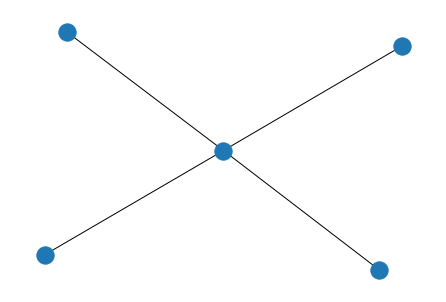

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import torch_geometric.utils as utils


height = 1
width = 1
hidden_dim = 8

n_inputs = 2
n_outputs = 2

def build_edges(n_inputs: int, n_outputs: int, height: int, width: int):
    """
    Builds edges like 2d_grid_graph
    """
    #hidden neurons
    edge_list = list(nx.grid_2d_graph(height, width).edges())
    node_list = list(nx.grid_2d_graph(height, width).nodes())


    #replace each element of edge_list with its index in node_list
    for i in range(len(edge_list)):
        edge_list[i] = (node_list.index(edge_list[i][0]), node_list.index(edge_list[i][1]))
        
    edges = torch.tensor(edge_list)
    
    #input neurons
    input_edges = torch.tensor([
        [
            [x, (height*width) + y] for x in range(width)
        ] for y in range(n_inputs)
    ]).view(-1, 2)

    #output neurons
    output_edges = torch.tensor([
        [
            [(height*width)-(x+1), (height*width) + y+n_inputs] for x in range(width)
        ] for y in range(n_outputs)
    ]).view(-1, 2)

    #merge edges and input_edges
    edges = torch.cat((edges, input_edges, output_edges), dim=0).transpose(0,1)
    return edges



edges = build_edges(n_inputs, n_outputs, height, width)

n_nodes = height*width + n_inputs + n_outputs

type_dict = {"hidden": [1, 0, 0], "input": [0, 1, 0], "output": [0, 0, 1]}
total_hidden_dim = hidden_dim + len(type_dict["hidden"]) #hidden data + type

# def set_node_state(input_data: torch.Tensor, output_data: torch.Tensor):
x = torch.zeros(n_nodes, total_hidden_dim)

n_hidden_nodes = height*width
x[:n_hidden_nodes] = torch.concat((torch.ones(hidden_dim)*(-1), torch.tensor(type_dict["hidden"])))
x[n_hidden_nodes:n_hidden_nodes+n_inputs] = torch.concat((torch.ones(hidden_dim)*(-1), torch.tensor(type_dict["input"])))
x[n_hidden_nodes+n_inputs:n_hidden_nodes+n_inputs+n_outputs] = torch.concat((torch.ones(hidden_dim)*(-1), torch.tensor(type_dict["output"])))



data = Data(edge_index=edges, x=x)

graph = utils.to_networkx(data, to_undirected=True, remove_self_loops = True)
nx.draw(graph)


In [8]:
#Pytorch geometric graph classification
from torch_geometric.nn import GCNConv


class UpdateRule(torch.nn.Module):
    def __init__(self, width = 4):
        super(UpdateRule, self).__init__()
        torch.manual_seed(12345)

        self.input_vectorizer = nn.Linear(n_inputs, hidden_dim)
        
        # Vectorizes training targets
        self.reverse_output_vectorizer = nn.Linear(n_outputs, hidden_dim, bias=True)
        
        self.output_vectorizer = nn.Linear(hidden_dim, 1)
        
        self.conv1 = GCNConv(total_hidden_dim+5, width)
        # self.conv1 = GCNConv(hidden_dim, width)
        self.conv2 = GCNConv(width, width)
        self.conv3 = GCNConv(width, hidden_dim)
        
        self.reset()

    def forward(self, x, edge_index):
        # x, types = remove_type(x.clone())
        types = get_type(x, hidden_dim=hidden_dim)
        x_original = x.clone()
        
        x = torch.concat((x, F.one_hot(torch.arange(0, 5))), -1)
        
        x = self.conv1(x, edge_index)
        
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        
        # x = x * (1- torch.abs(x_original[:,:hidden_dim]))
        
        # x = x + x_original[:,:hidden_dim]
        x = x.tanh()
        
        x = torch.cat([x, types], dim=-1)
        return x
    
    def print_grad(self):
        # for idx,i in enumerate([self.input_vectorizer, self.output_vectorizer]):
        #     print(idx)
        #     print(i.weight.grad)
        #     print()
            
        for idx,i in enumerate([self.conv1]):
            print(idx)
            print(i.lin.weight.grad)
            print()
    
    def reset_inputs(self, x, input_data):
        """
        Args:
            x: Network state before rule application
            input_data: Training logits
        """
        # if self.vectorized_input is None:
        input_indices = torch.argwhere((x[:,hidden_dim:] == torch.tensor(type_dict["input"])).all(1)).squeeze(-1)
        
        vectorized_input = torch.concat((self.input_vectorizer(input_data), torch.tensor([[0,0,0]])), -1)
        # vectorized_input[input_indices, hidden_dim:] += torch.tensor([0,1,0]).unsqueeze(0).float()
        
        
        mask = torch.zeros(x.shape)
        mask[input_indices, :hidden_dim] = 1
        x = x - (x * mask)
        x = x + (vectorized_input*mask)
        # x[input_indices, :hidden_dim] = vectorized_input
        return x

    def reset_outputs(self, x, output_data):
        """
        Args:
            x: Network state before rule application
            output_data: Training targets
        """
        if self.vectorized_output is None:
            self.vectorized_output = self.reverse_output_vectorizer(output_data)
        
        output_indices = torch.argwhere((x[:,hidden_dim:] == torch.tensor(type_dict["output"])).all(1)).squeeze(-1)
        x[output_indices, :hidden_dim] = self.vectorized_input
        return x
    
    def get_output(self, x):
        """
        Args:
            x: Network state after rule application
        """
        output_indices = torch.argwhere((x[:,hidden_dim:] == torch.tensor(type_dict["output"])).all(1)).squeeze(-1)
        return self.output_vectorizer(x[output_indices, :hidden_dim]).sigmoid().squeeze(-1)
        
    
    def reset(self):
        self.vectorized_input = None
        self.vectorized_output = None
        
            
update_rule = UpdateRule()


In [9]:
%matplotlib notebook
from utils import reset_inputs, get_type, remove_type, get_output
from tqdm.notebook import tqdm
import time

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()


class SelfOrganizeTest(torch.nn.Module):
    """
    If Rule can learn this data, then it can somewhat self organize
    """
    def __init__(self) :
        super().__init__()
        self.data = torch.tensor([[0,1]])
        self.target = torch.tensor([[0,1]])
        
    def __getitem__(self, index):
        return self.data[index], self.target[index]
    def __len__(self):
        return len(self.data)

class ANDDataset(torch.utils.data.Dataset):
    def __init__(self):
        # self.data = torch.tensor([[-1,-1], [-1,1], [1,-1], [1,1]])
        # self.target = [-1,1,1,-1]
        self.data = torch.tensor([[0,0], [1,1],[0,0], [1,1]])
        self.target = torch.tensor([[0],[1],[0],[1]])
        
        
    def __getitem__(self, index):
        return self.data[index], self.target[index]
    def __len__(self):
        return len(self.data)
    
class TranslateDataset(torch.utils.data.Dataset):
    def __init__(self) -> None:
        super().__init__()
        self.data = torch.tensor([[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]])
        self.target = torch.tensor([[0,1,0,0], [0,0,1,0], [0,0,0,1], [1,0,0,0]])
        
    def __getitem__(self, index):
        return self.data[index], self.target[index]
    def __len__(self):
        return len(self.data)

        
dataset_loader = DataLoader(SelfOrganizeTest(), batch_size=1, shuffle=False)
# dataset_loader = DataLoader(ANDDataset(), batch_size=1, shuffle=False)
# dataset_loader = DataLoader(TranslateDataset(), batch_size=1, shuffle=True)

update_rule = UpdateRule()

optimizer = torch.optim.Adam(update_rule.parameters(), lr=0.003)

losses = []
n_steps = 20
batch_size = 25
for epoch in range(2000):
    loss = 0
    for _ in range(batch_size):
        update_rule.reset() 
        
        batch_loss = 0
        x = data.x.float().clone()
        #replace all the -1 values in x with a random value
        x[x == -1] = torch.rand(n_nodes * hidden_dim)
        for idx, (problem_data_x, problem_data_y) in enumerate(dataset_loader):
           
            for i in range(n_steps):
                # if idx == len(dataset_loader)-1:
                output_node_data = torch.zeros(problem_data_y.shape)
                # else:
                # output_node_data = problem_data_y
                # x = reset_inputs(x, problem_data_x.float(), output_node_data.float(), hidden_dim=hidden_dim).float()
                x = update_rule.reset_inputs(x, problem_data_x.float())
                x = update_rule(x, data.edge_index.long())
                
            
            # if idx == len(dataset_loader)-1:
            # print(problem_data_x,network_output)
            network_output = update_rule.get_output(x)
            batch_loss += F.mse_loss(problem_data_y.float().squeeze(0), network_output)
         
        loss += batch_loss
    
    loss /= batch_size
    # print()
    # break
    # loss /= (5 * n_steps * len(dataset_loader))
    
    losses.append(loss.item())
        
    loss.backward()  
    # update_rule.print_grad()
    optimizer.step()  
    optimizer.zero_grad()  
    print(f"\r Epoch {epoch * batch_size} | Loss {loss} | Network out: {network_output} | {x.mean()}", end="")
    
    if epoch % (100 // batch_size) == 0:
        print()

ax.clear()
ax.plot(losses)
fig.canvas.draw()

<IPython.core.display.Javascript object>

tensor([[0.3540, 0.4020, 0.1191, 0.3095, 0.3373, 0.9459, 0.2754, 0.3898, 1.0000,
         0.0000, 0.0000],
        [0.9163, 0.1798, 0.4661, 0.2642, 0.7045, 0.8060, 0.6571, 0.2227, 0.0000,
         1.0000, 0.0000],
        [0.6620, 0.2616, 0.0914, 0.9544, 0.8611, 0.3333, 0.7642, 0.4940, 0.0000,
         1.0000, 0.0000],
        [0.6795, 0.4967, 0.8998, 0.8476, 0.4607, 0.5108, 0.9737, 0.7299, 0.0000,
         0.0000, 1.0000],
        [0.0140, 0.4121, 0.3553, 0.3769, 0.4874, 0.3448, 0.7698, 0.0070, 0.0000,
         0.0000, 1.0000]])
tensor([[ 0.3540,  0.4020,  0.1191,  0.3095,  0.3373,  0.9459,  0.2754,  0.3898,
          1.0000,  0.0000,  0.0000],
        [ 0.8481,  0.2615, -0.7180,  0.3406, -0.5276,  0.3611, -0.9225,  0.4740,
          0.0000,  1.0000,  0.0000],
        [ 0.8481,  0.2615, -0.7180,  0.3406, -0.5276,  0.3611, -0.9225,  0.4740,
          0.0000,  1.0000,  0.0000],
        [ 0.6795,  0.4967,  0.8998,  0.8476,  0.4607,  0.5108,  0.9737,  0.7299,
          0.0000,  0.0000,  1

KeyboardInterrupt: 

In [ ]:
import numpy as np
np.set_printoptions(precision=3)


def run_rule(data_x, update_rule, n_steps = 51):
    x = data.x.float().clone()
    x[x == -1] = torch.rand(n_nodes * hidden_dim)
    
    for i in range(n_steps):
        x = update_rule.reset_inputs(x, problem_data_x.float())
        x = update_rule(x, data.edge_index.long())
    
        network_output = update_rule.get_output(x)
        print(network_output)
    return network_output
    

run_rule(torch.tensor([[1,0]]), update_rule)

RuntimeError: shape mismatch: value tensor of shape [3] cannot be broadcast to indexing result of shape [2, 11]

In [ ]:
import numpy as np
np.set_printoptions(precision=3)

x[:, 0].detach().numpy()

In [ ]:
#pytorch random tensor
torch.rand(1)

In [ ]:
torch.tensor([[1,2],[3,4]])[0,[0,1]]

In [ ]:
from torch.functional import F

torch.concat((torch.zeros([5,11]), F.one_hot(torch.arange(0, 5))), -1)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

tensor([0, 1, 2, 0, 1])